# Relevant **Libraries**

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install fastai==1.0.59

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.1/354.1 kB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylin

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from functools import partial
from torch import save
from fastai.basic_train import Learner
#from fastai.train import ShowGraph
from fastai.data_block import DataBunch
from torch import optim

In [ ]:
import nibabel as nib

In [ ]:
from itertools import product
import numpy as np
import torch
from skimage.measure import regionprops
from torch.utils.data import DataLoader, Dataset

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Setting Up **Dataset**

In [ ]:
class FracNetTrainDataset(Dataset):

    def __init__(self, image_dir, label_dir=None, crop_size=64,
            transforms=None, num_samples=4, train=True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.public_id_list = sorted([x.split("-")[0]
            for x in os.listdir(image_dir)])
        self.crop_size = crop_size
        self.transforms = transforms
        self.num_samples = num_samples
        self.train = train

    def __len__(self):
        return len(self.public_id_list)

    @staticmethod
    def _get_pos_centroids(label_arr):
        centroids = [tuple([round(x) for x in prop.centroid])
            for prop in regionprops(label_arr)]

        return centroids

    @staticmethod
    def _get_symmetric_neg_centroids(pos_centroids, x_size):
        sym_neg_centroids = [(x_size - x, y, z) for x, y, z in pos_centroids]

        return sym_neg_centroids

    @staticmethod
    def _get_spine_neg_centroids(shape, crop_size, num_samples):
        x_min, x_max = shape[0] // 2 - 40, shape[0] // 2 + 40
        y_min, y_max = 300, 400
        z_min, z_max = crop_size // 2, shape[2] - crop_size // 2
        spine_neg_centroids = [(
            np.random.randint(x_min, x_max),
            np.random.randint(y_min, y_max),
            np.random.randint(z_min, z_max)
        ) for _ in range(num_samples)]

        return spine_neg_centroids

    def _get_neg_centroids(self, pos_centroids, image_shape):
        num_pos = len(pos_centroids)
        sym_neg_centroids = self._get_symmetric_neg_centroids(
            pos_centroids, image_shape[0])

        if num_pos < self.num_samples // 2:
            spine_neg_centroids = self._get_spine_neg_centroids(image_shape,
                self.crop_size, self.num_samples - 2 * num_pos)
        else:
            spine_neg_centroids = self._get_spine_neg_centroids(image_shape,
                self.crop_size, num_pos)

        return sym_neg_centroids + spine_neg_centroids

    def _get_roi_centroids(self, label_arr):
        if self.train:
            # generate positive samples' centroids
            pos_centroids = self._get_pos_centroids(label_arr)

            # generate negative samples' centroids
            neg_centroids = self._get_neg_centroids(pos_centroids,
                label_arr.shape)

            # sample positives and negatives when necessary
            num_pos = len(pos_centroids)
            num_neg = len(neg_centroids)
            if num_pos >= self.num_samples:
                num_pos = self.num_samples // 2
                num_neg = self.num_samples // 2
            elif num_pos >= self.num_samples // 2:
                num_neg = self.num_samples - num_pos

            if num_pos < len(pos_centroids):
                pos_centroids = [pos_centroids[i] for i in np.random.choice(
                    range(0, len(pos_centroids)), size=num_pos, replace=False)]
            if num_neg < len(neg_centroids):
                neg_centroids = [neg_centroids[i] for i in np.random.choice(
                    range(0, len(neg_centroids)), size=num_neg, replace=False)]

            roi_centroids = pos_centroids + neg_centroids
        else:
            roi_centroids = [list(range(0, x, y // 2))[1:-1] + [x - y // 2]
                for x, y in zip(label_arr.shape, self.crop_size)]
            roi_centroids = list(product(*roi_centroids))

        roi_centroids = [tuple([int(x) for x in centroid])
            for centroid in roi_centroids]

        return roi_centroids

    def _crop_roi(self, arr, centroid):
        roi = np.ones(tuple([self.crop_size] * 3)) * (-1024)

        src_beg = [max(0, centroid[i] - self.crop_size // 2)
            for i in range(len(centroid))]
        src_end = [min(arr.shape[i], centroid[i] + self.crop_size // 2)
            for i in range(len(centroid))]
        dst_beg = [max(0, self.crop_size // 2 - centroid[i])
            for i in range(len(centroid))]
        dst_end = [min(arr.shape[i] - (centroid[i] - self.crop_size // 2),
            self.crop_size) for i in range(len(centroid))]
        roi[
            dst_beg[0]:dst_end[0],
            dst_beg[1]:dst_end[1],
            dst_beg[2]:dst_end[2],
        ] = arr[
            src_beg[0]:src_end[0],
            src_beg[1]:src_end[1],
            src_beg[2]:src_end[2],
        ]

        return roi

    def _apply_transforms(self, image):
        for t in self.transforms:
            image = t(image)

        return image

    def __getitem__(self, idx):
        # read image and label
        public_id = self.public_id_list[idx]
        image_path = os.path.join(self.image_dir, f"{public_id}-image.nii")
        label_path = os.path.join(self.label_dir, f"{public_id}-label.nii")
        image = nib.load(image_path)
        label = nib.load(label_path)
        image_arr = image.get_fdata().astype(float)
        label_arr = label.get_fdata().astype(np.uint8)

        # calculate rois' centroids
        roi_centroids = self._get_roi_centroids(label_arr)

        # crop rois
        image_rois = [self._crop_roi(image_arr, centroid)
            for centroid in roi_centroids]
        label_rois = [self._crop_roi(label_arr, centroid)
            for centroid in roi_centroids]

        if self.transforms is not None:
            image_rois = [self._apply_transforms(image_roi)
                for image_roi in image_rois]

        image_rois = torch.tensor(np.stack(image_rois)[:, np.newaxis],
            dtype=torch.float)
        label_rois = (np.stack(label_rois) > 0).astype(float)
        label_rois = torch.tensor(label_rois[:, np.newaxis],
            dtype=torch.float)

        return image_rois, label_rois

    @staticmethod
    def collate_fn(samples):
        image_rois = torch.cat([x[0] for x in samples])
        label_rois = torch.cat([x[1] for x in samples])

        return image_rois, label_rois

    @staticmethod
    def get_dataloader(dataset, batch_size, shuffle=False, num_workers=0):
        return DataLoader(dataset, batch_size, shuffle,
            num_workers=num_workers, collate_fn=FracNetTrainDataset.collate_fn)

dataset = FracNetTrainDataset("/content/drive/MyDrive/ML_Project/train/train_images", "/content/drive/MyDrive/ML_Project/train/train_labels")
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

# Just iterate through one batch to see the outputs
for data in data_loader:
    break


# Transformations

In [ ]:
class Window:

    def __init__(self, window_min, window_max):
        self.window_min = window_min
        self.window_max = window_max

    def __call__(self, image):
        image = np.clip(image, self.window_min, self.window_max)

        return image


class MinMaxNorm:

    def __init__(self, low, high):
        self.low = low
        self.high = high

    def __call__(self, image):
        image = (image - self.low) / (self.high - self.low)
        image = image * 2 - 1

        return image

import random

class AddGaussianNoise:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
      image = torch.from_numpy(image)
      noise = torch.randn_like(image) * self.std + self.mean
      noise_image = image + noise
      return noise_image


# Metrics

In [ ]:
#metrics
def dice(x, y, image=False):
    x = x.sigmoid()
    i, u = [t.flatten(1).sum(1) if image else t.sum() for t in [x * y, x + y]]
    dc = ((2 * i + 1) / (u + 1)).mean()
    return dc


def recall(x, y, thresh=0.1):
    x = x.sigmoid()
    tp = (((x * y) > thresh).flatten(1).sum(1) > 0).sum()
    rc = tp / (((y > 0).flatten(1).sum(1) > 0).sum() + 1e-8)
    return rc


def accuracy(x, y, thresh=0.5):
    x = x.sigmoid()
    ac = ((x > thresh) == (y > 0)).float().mean()
    return ac


def precision(x, y, thresh=0.1):
    x = x.sigmoid()
    tp = (((x * y) > thresh).flatten(1).sum(1) > 0).sum()
    pc = tp / (((x > thresh).flatten(1).sum(1) > 0).sum() + 1e-8)
    return pc


def fbeta_score(x, y, beta=1, **kwargs):
    rc = recall(x, y, **kwargs)
    pc = precision(x, y, **kwargs)
    fs = (1 + beta ** 2) * pc * rc / (beta ** 2 * pc + rc + 1e-8)
    return fs

# Edge Index

In [ ]:
def create_edge_index_3d(d, h, w):
    """ Create a tensor of node indices shaped as a 3D grid """
    # this tensor allows mapping 3D positions to linear node indices in the graph representation
    idx = torch.arange(d * h * w).view(d, h, w)
    edges = []  # list to store edges

    """ iterate over each element in the 3D grid to establish connectivity """
    for k in range(d):  # loop through depth
        for i in range(h):  # loop through height
            for j in range(w):  # loop through the width
                # calculate linear index of the current node based on its position in the grid
                node_index = k * h * w + i * w + j

                """ connect each node with its neighbor along the depth (z-axis) """
                if k < d - 1:  #ensure connection is within bounds
                    # add forward connection along depth
                    edges.append((node_index, node_index + h * w))
                    # add backward connection (for undirected graph)
                    edges.append((node_index + h * w, node_index))

                """ connect each node with its neighbor below (along the height, y-axis) """
                if i < h - 1:
                    # downward connection
                    edges.append((node_index, node_index + w))
                    # upward connection (for undirected graph)
                    edges.append((node_index + w, node_index))

                """ connect each node with its neighbor to the right (along the width, x-axis) """
                if j < w - 1:
                    # rightward connection
                    edges.append((node_index, node_index + 1))
                    # leftward connection (for undirected graph)
                    edges.append((node_index + 1, node_index))

    """ convert the list of edges into a PyTorch tensor of shape [2, num_edges] """
    # first row contains source nodes, the second row contains destination nodes
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

# **Model**

In [ ]:
#model
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # two GCNConv layers followed by ReLU activation
        self.conv1 = GCNConv(in_channels, out_channels)
        self.conv2 = GCNConv(out_channels, out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, edge_index):
        # first GCN layer
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        # second GCN layer
        x = self.conv2(x, edge_index)
        return x

class UNetWithGCN(nn.Module):
    def __init__(self, in_channels, num_classes, first_out_channels=16):
        super().__init__()
        # initial convolution block
        self.first = ConvBlock(in_channels, first_out_channels)
        # down-sampling layers
        self.down1 = Down(first_out_channels, 2 * first_out_channels)
        self.down2 = Down(2 * first_out_channels, 4 * first_out_channels)
        self.down3 = Down(4 * first_out_channels, 8 * first_out_channels)
        # GCN block applied at the bottleneck
        self.gcn = GCNBlock(8 * first_out_channels, 8 * first_out_channels)
        # up-sampling layers
        self.up1 = Up(8 * first_out_channels, 4 * first_out_channels)
        self.up2 = Up(4 * first_out_channels, 2 * first_out_channels)
        self.up3 = Up(2 * first_out_channels, first_out_channels)
        # final convolution to produce the output segmentation map
        self.final = nn.Conv3d(first_out_channels, num_classes, 1)

    def forward(self, x):
        # sequential application of down-sampling layers
        x1 = self.first(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)  # output from the last down-sampling layer

        # convert tensor for GCN input and calculate edge_index - Preparing data for GCN
        batch_size, channels, d, h, w = x4.size()
        num_nodes = d * h * w
        num_features = channels
        x4_flat = x4.view(batch_size * num_nodes, num_features)  # reshape (flatten) for GCN input
        edge_index = create_edge_index_3d(d, h, w)
        edge_index = edge_index.to(x4.device)

        # apply the GCN layer
        x4_flat = self.gcn(x4_flat, edge_index)

        # reshape back to (original) spatial dimensions for up-sampling
        x4 = x4_flat.view(batch_size, channels, d, h, w)

        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.final(x)
        return x


class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv3d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(inplace=True)
        )


class Down(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.MaxPool3d(2),
            ConvBlock(in_channels, out_channels)
        )


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, 2, stride=2, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x, y):
        x = self.conv2(x)  # apply transposed convolution
        x = self.conv1(torch.cat([y, x], dim=1))  # concatenate feature maps and apply convolution
        return x

# Losses

In [ ]:
from functools import reduce

import torch
import torch.nn as nn
import torch.nn.functional as F


__all__ = ['MixLoss', 'DiceLoss', 'GHMCLoss', 'FocalLoss']


class MixLoss(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.args = args

    def forward(self, x, y):
        lf, lfw = [], []
        for i, v in enumerate(self.args):
            if i % 2 == 0:
                lf.append(v)
            else:
                lfw.append(v)
        mx = sum([w * l(x, y) for l, w in zip(lf, lfw)])
        return mx


class DiceLoss(nn.Module):
    def __init__(self, image=False):
        super().__init__()
        self.image = image

    def forward(self, x, y):
        x = x.sigmoid()
        i, u = [t.flatten(1).sum(1) if self.image else t.sum() for t in [x * y, x + y]]

        dc = (2 * i + 1) / (u + 1)
        dc = 1 - dc.mean()
        return dc

In [ ]:
#move model to GPU
model = UNetWithGCN(1, 1, first_out_channels=16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UNetWithGCN(
  (first): ConvBlock(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (down1): Down(
    (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ConvBlock(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (4): BatchNorm

# **Training** and Evaluation

In [ ]:
from tqdm import tqdm
import time

In [ ]:
!pip install matplotlib

Training Epoch 1/50:   0%|          | 0/14 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Validation Epoch 1/50: 100%|██████████| 5/5 [07:36<00:00, 91.25s/it]


Epoch 1/50 - Train Loss: 1.2756, Val Loss: 1.2410, Dice: 0.0234, Recall: 0.0154, Precision: 0.2000, Fbeta: 0.0286, Time: 1427.33 sec


Validation Epoch 2/50: 100%|██████████| 5/5 [06:59<00:00, 83.85s/it]


Epoch 2/50 - Train Loss: 1.1135, Val Loss: 1.0942, Dice: 0.0345, Recall: 0.7469, Precision: 0.3504, Fbeta: 0.4701, Time: 1500.47 sec


Validation Epoch 3/50: 100%|██████████| 5/5 [05:59<00:00, 71.93s/it]


Epoch 3/50 - Train Loss: 1.0306, Val Loss: 1.0371, Dice: 0.0577, Recall: 0.9190, Precision: 0.3839, Fbeta: 0.5356, Time: 1395.74 sec


Validation Epoch 4/50: 100%|██████████| 5/5 [06:34<00:00, 78.99s/it]


Epoch 4/50 - Train Loss: 0.9623, Val Loss: 0.9880, Dice: 0.0641, Recall: 0.7662, Precision: 0.3622, Fbeta: 0.4866, Time: 1360.80 sec


Validation Epoch 5/50: 100%|██████████| 5/5 [05:46<00:00, 69.27s/it]


Epoch 5/50 - Train Loss: 0.8801, Val Loss: 0.9039, Dice: 0.1391, Recall: 0.8871, Precision: 0.4043, Fbeta: 0.5517, Time: 1370.46 sec


Validation Epoch 6/50: 100%|██████████| 5/5 [06:17<00:00, 75.51s/it]


Epoch 6/50 - Train Loss: 0.8042, Val Loss: 0.8574, Dice: 0.1775, Recall: 0.8694, Precision: 0.3995, Fbeta: 0.5450, Time: 1466.16 sec


Validation Epoch 7/50: 100%|██████████| 5/5 [06:38<00:00, 79.63s/it]


Epoch 7/50 - Train Loss: 0.7257, Val Loss: 0.8540, Dice: 0.1853, Recall: 0.9846, Precision: 0.4443, Fbeta: 0.6067, Time: 1494.77 sec


Validation Epoch 8/50: 100%|██████████| 5/5 [07:06<00:00, 85.36s/it]


Epoch 8/50 - Train Loss: 0.7005, Val Loss: 1.0126, Dice: 0.0179, Recall: 0.0904, Precision: 0.1328, Fbeta: 0.1042, Time: 1472.58 sec


Validation Epoch 9/50: 100%|██████████| 5/5 [06:32<00:00, 78.50s/it]


Epoch 9/50 - Train Loss: 0.6625, Val Loss: 0.7681, Dice: 0.2651, Recall: 0.8476, Precision: 0.3986, Fbeta: 0.5382, Time: 1442.93 sec


Validation Epoch 10/50: 100%|██████████| 5/5 [07:04<00:00, 84.90s/it]


Epoch 10/50 - Train Loss: 0.6204, Val Loss: 0.9575, Dice: 0.0731, Recall: 0.5573, Precision: 0.3648, Fbeta: 0.4350, Time: 1444.98 sec


Validation Epoch 11/50: 100%|██████████| 5/5 [06:46<00:00, 81.36s/it]


Epoch 11/50 - Train Loss: 0.5568, Val Loss: 0.7633, Dice: 0.2887, Recall: 1.0000, Precision: 0.4408, Fbeta: 0.6065, Time: 1549.62 sec


Validation Epoch 12/50: 100%|██████████| 5/5 [06:38<00:00, 79.64s/it]


Epoch 12/50 - Train Loss: 0.5018, Val Loss: 0.7961, Dice: 0.2283, Recall: 0.5374, Precision: 0.5955, Fbeta: 0.5588, Time: 1508.23 sec


Validation Epoch 13/50: 100%|██████████| 5/5 [06:37<00:00, 79.50s/it]


Epoch 13/50 - Train Loss: 0.5217, Val Loss: 0.9077, Dice: 0.1194, Recall: 0.3957, Precision: 0.8695, Fbeta: 0.5362, Time: 1436.77 sec


Validation Epoch 14/50: 100%|██████████| 5/5 [06:24<00:00, 76.85s/it]


Epoch 14/50 - Train Loss: 0.4756, Val Loss: 0.5158, Dice: 0.5038, Recall: 0.8435, Precision: 0.8421, Fbeta: 0.8382, Time: 1385.66 sec


Validation Epoch 15/50: 100%|██████████| 5/5 [06:04<00:00, 72.81s/it]


Epoch 15/50 - Train Loss: 0.4609, Val Loss: 0.5211, Dice: 0.5036, Recall: 0.9229, Precision: 0.5511, Fbeta: 0.6833, Time: 1407.46 sec


Validation Epoch 16/50: 100%|██████████| 5/5 [05:54<00:00, 70.81s/it]


Epoch 16/50 - Train Loss: 0.4623, Val Loss: 0.9271, Dice: 0.2637, Recall: 0.9399, Precision: 0.3992, Fbeta: 0.5549, Time: 1345.73 sec


Validation Epoch 17/50: 100%|██████████| 5/5 [05:38<00:00, 67.63s/it]


Epoch 17/50 - Train Loss: 0.4600, Val Loss: 0.5628, Dice: 0.4665, Recall: 0.9857, Precision: 0.7324, Fbeta: 0.8373, Time: 1298.82 sec


Validation Epoch 18/50: 100%|██████████| 5/5 [05:36<00:00, 67.35s/it]


Epoch 18/50 - Train Loss: 0.4252, Val Loss: 0.4497, Dice: 0.5747, Recall: 0.9222, Precision: 0.7068, Fbeta: 0.7984, Time: 1340.31 sec


Validation Epoch 19/50: 100%|██████████| 5/5 [05:53<00:00, 70.68s/it]


Epoch 19/50 - Train Loss: 0.4421, Val Loss: 0.4958, Dice: 0.5220, Recall: 0.8510, Precision: 0.6851, Fbeta: 0.7559, Time: 1320.89 sec


Validation Epoch 20/50: 100%|██████████| 5/5 [05:22<00:00, 64.58s/it]


Epoch 20/50 - Train Loss: 0.3888, Val Loss: 0.4613, Dice: 0.5653, Recall: 0.9735, Precision: 0.6624, Fbeta: 0.7859, Time: 1310.71 sec


Validation Epoch 21/50: 100%|██████████| 5/5 [05:31<00:00, 66.32s/it]


Epoch 21/50 - Train Loss: 0.3868, Val Loss: 0.4651, Dice: 0.5600, Recall: 0.9370, Precision: 0.6429, Fbeta: 0.7569, Time: 1276.57 sec


Validation Epoch 22/50: 100%|██████████| 5/5 [05:17<00:00, 63.57s/it]


Epoch 22/50 - Train Loss: 0.3996, Val Loss: 0.9862, Dice: 0.2070, Recall: 0.9714, Precision: 0.4395, Fbeta: 0.5982, Time: 1217.05 sec


Validation Epoch 23/50: 100%|██████████| 5/5 [05:20<00:00, 64.19s/it]


Epoch 23/50 - Train Loss: 0.3799, Val Loss: 0.4241, Dice: 0.5980, Recall: 0.9121, Precision: 0.7205, Fbeta: 0.8007, Time: 1188.48 sec


Validation Epoch 24/50: 100%|██████████| 5/5 [05:26<00:00, 65.29s/it]


Epoch 24/50 - Train Loss: 0.3507, Val Loss: 0.5608, Dice: 0.4824, Recall: 0.9647, Precision: 0.4517, Fbeta: 0.6085, Time: 1204.14 sec


Validation Epoch 25/50: 100%|██████████| 5/5 [05:14<00:00, 62.81s/it]


Epoch 25/50 - Train Loss: 0.3690, Val Loss: 0.4470, Dice: 0.5756, Recall: 0.9337, Precision: 0.6713, Fbeta: 0.7766, Time: 1173.84 sec


Validation Epoch 26/50: 100%|██████████| 5/5 [05:00<00:00, 60.15s/it]


Epoch 26/50 - Train Loss: 0.3345, Val Loss: 0.7852, Dice: 0.3134, Recall: 0.9636, Precision: 0.4354, Fbeta: 0.5940, Time: 1157.32 sec


Validation Epoch 27/50: 100%|██████████| 5/5 [05:44<00:00, 68.86s/it]


Epoch 27/50 - Train Loss: 0.3685, Val Loss: 0.5086, Dice: 0.5180, Recall: 0.9147, Precision: 0.8753, Fbeta: 0.8918, Time: 1206.30 sec


Validation Epoch 28/50: 100%|██████████| 5/5 [04:58<00:00, 59.61s/it]


Epoch 28/50 - Train Loss: 0.3571, Val Loss: 0.4309, Dice: 0.5967, Recall: 0.9552, Precision: 0.6940, Fbeta: 0.8031, Time: 1153.22 sec


Validation Epoch 29/50: 100%|██████████| 5/5 [05:15<00:00, 63.18s/it]


Epoch 29/50 - Train Loss: 0.3554, Val Loss: 0.4119, Dice: 0.6086, Recall: 0.9197, Precision: 0.8764, Fbeta: 0.8911, Time: 1173.30 sec


Validation Epoch 30/50: 100%|██████████| 5/5 [05:27<00:00, 65.55s/it]


Epoch 30/50 - Train Loss: 0.3157, Val Loss: 0.4692, Dice: 0.5551, Recall: 0.9464, Precision: 0.5132, Fbeta: 0.6605, Time: 1234.44 sec


Validation Epoch 31/50: 100%|██████████| 5/5 [05:29<00:00, 65.81s/it]


Epoch 31/50 - Train Loss: 0.3383, Val Loss: 0.6323, Dice: 0.3962, Recall: 0.7179, Precision: 0.8168, Fbeta: 0.7571, Time: 1289.93 sec


Validation Epoch 32/50: 100%|██████████| 5/5 [06:13<00:00, 74.69s/it]


Epoch 32/50 - Train Loss: 0.3491, Val Loss: 0.5138, Dice: 0.5206, Recall: 0.9846, Precision: 0.5865, Fbeta: 0.7325, Time: 1318.77 sec


Validation Epoch 33/50: 100%|██████████| 5/5 [05:29<00:00, 65.93s/it]


Epoch 33/50 - Train Loss: 0.3088, Val Loss: 0.4454, Dice: 0.5819, Recall: 0.9220, Precision: 0.6801, Fbeta: 0.7782, Time: 1292.95 sec


Validation Epoch 34/50: 100%|██████████| 5/5 [06:05<00:00, 73.08s/it]


Epoch 34/50 - Train Loss: 0.2970, Val Loss: 0.5734, Dice: 0.4877, Recall: 0.9664, Precision: 0.4839, Fbeta: 0.6386, Time: 1359.14 sec


Validation Epoch 35/50: 100%|██████████| 5/5 [06:03<00:00, 72.74s/it]


Epoch 35/50 - Train Loss: 0.3201, Val Loss: 0.9236, Dice: 0.1838, Recall: 0.9846, Precision: 0.4161, Fbeta: 0.5800, Time: 1343.26 sec


Validation Epoch 36/50: 100%|██████████| 5/5 [05:55<00:00, 71.17s/it]


Epoch 36/50 - Train Loss: 0.3463, Val Loss: 0.4421, Dice: 0.5788, Recall: 0.9175, Precision: 0.8084, Fbeta: 0.8566, Time: 1348.64 sec


Validation Epoch 37/50: 100%|██████████| 5/5 [06:09<00:00, 73.95s/it]


Epoch 37/50 - Train Loss: 0.3050, Val Loss: 0.4532, Dice: 0.5680, Recall: 0.9210, Precision: 0.8302, Fbeta: 0.8723, Time: 1369.65 sec


Validation Epoch 38/50: 100%|██████████| 5/5 [06:16<00:00, 75.29s/it]


Epoch 38/50 - Train Loss: 0.3059, Val Loss: 0.4900, Dice: 0.5395, Recall: 0.9268, Precision: 0.5226, Fbeta: 0.6630, Time: 1357.61 sec


Validation Epoch 39/50: 100%|██████████| 5/5 [06:18<00:00, 75.79s/it]


Epoch 39/50 - Train Loss: 0.3075, Val Loss: 0.4760, Dice: 0.5580, Recall: 0.9622, Precision: 0.5300, Fbeta: 0.6799, Time: 1403.43 sec


Validation Epoch 40/50: 100%|██████████| 5/5 [06:13<00:00, 74.64s/it]


Epoch 40/50 - Train Loss: 0.3074, Val Loss: 0.4279, Dice: 0.5956, Recall: 0.9568, Precision: 0.8518, Fbeta: 0.9003, Time: 1387.12 sec


Validation Epoch 41/50: 100%|██████████| 5/5 [06:16<00:00, 75.39s/it]


Epoch 41/50 - Train Loss: 0.2942, Val Loss: 0.4139, Dice: 0.6099, Recall: 0.9404, Precision: 0.8014, Fbeta: 0.8636, Time: 1438.23 sec


Validation Epoch 42/50: 100%|██████████| 5/5 [06:14<00:00, 74.98s/it]


Epoch 42/50 - Train Loss: 0.2961, Val Loss: 0.4591, Dice: 0.5591, Recall: 0.8368, Precision: 0.9457, Fbeta: 0.8871, Time: 1435.18 sec


Validation Epoch 43/50: 100%|██████████| 5/5 [06:25<00:00, 77.17s/it]


Epoch 43/50 - Train Loss: 0.3199, Val Loss: 0.4832, Dice: 0.5423, Recall: 0.8523, Precision: 0.9223, Fbeta: 0.8827, Time: 1406.92 sec


Validation Epoch 44/50: 100%|██████████| 5/5 [05:56<00:00, 71.31s/it]


Epoch 44/50 - Train Loss: 0.3031, Val Loss: 0.3823, Dice: 0.6404, Recall: 0.9703, Precision: 0.6886, Fbeta: 0.8036, Time: 1423.44 sec


Validation Epoch 45/50: 100%|██████████| 5/5 [06:26<00:00, 77.38s/it]


Epoch 45/50 - Train Loss: 0.2864, Val Loss: 0.4199, Dice: 0.6040, Recall: 0.8910, Precision: 0.6822, Fbeta: 0.7619, Time: 1488.46 sec


Validation Epoch 46/50: 100%|██████████| 5/5 [07:01<00:00, 84.34s/it]


Epoch 46/50 - Train Loss: 0.2818, Val Loss: 0.5720, Dice: 0.4735, Recall: 0.9203, Precision: 0.5604, Fbeta: 0.6943, Time: 1469.46 sec


Validation Epoch 47/50: 100%|██████████| 5/5 [06:15<00:00, 75.07s/it]


Epoch 47/50 - Train Loss: 0.3135, Val Loss: 0.4160, Dice: 0.6100, Recall: 0.9857, Precision: 0.6536, Fbeta: 0.7853, Time: 1454.18 sec


Validation Epoch 48/50: 100%|██████████| 5/5 [06:24<00:00, 76.98s/it]


Epoch 48/50 - Train Loss: 0.2737, Val Loss: 0.3887, Dice: 0.6336, Recall: 0.9703, Precision: 0.8130, Fbeta: 0.8843, Time: 1511.34 sec


Validation Epoch 49/50: 100%|██████████| 5/5 [06:45<00:00, 81.18s/it]


Epoch 49/50 - Train Loss: 0.2694, Val Loss: 0.4472, Dice: 0.5811, Recall: 0.9109, Precision: 0.8813, Fbeta: 0.8941, Time: 1517.16 sec


Validation Epoch 50/50: 100%|██████████| 5/5 [07:30<00:00, 90.13s/it]


Epoch 50/50 - Train Loss: 0.2645, Val Loss: 0.5676, Dice: 0.4725, Recall: 0.9679, Precision: 0.4586, Fbeta: 0.6195, Time: 1617.21 sec


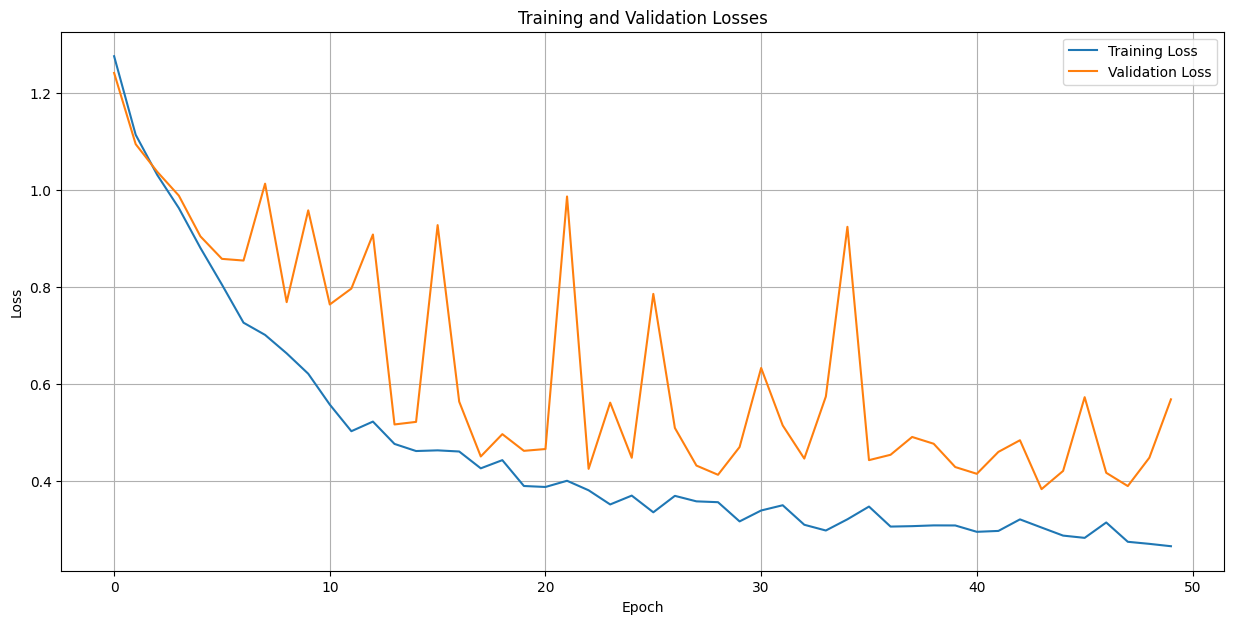

In [ ]:
train_image_dir = "/content/drive/MyDrive/ML_Project/train/train_images"
train_label_dir = "/content/drive/MyDrive/ML_Project/train/train_labels"
val_image_dir = "/content/drive/MyDrive/ML_Project/val/val_images"
val_label_dir = "/content/drive/MyDrive/ML_Project/val/val_labels"

batch_size = 8 #try with 16
num_workers = 1
optimizer = optim.SGD
criterion = MixLoss(nn.BCEWithLogitsLoss(), 0.5, DiceLoss(), 1)

thresh = 0.5
recall_partial = partial(recall, thresh=thresh)
precision_partial = partial(precision, thresh=thresh)
fbeta_score_partial = partial(fbeta_score, thresh=thresh)

# setting up the model
model = UNetWithGCN(1, 1, first_out_channels=16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # send model to GPU

# image transformations
transforms = [
    Window(-200, 1000),
    MinMaxNorm(-200, 1000),
    #AddRandomNoise(0.1)
    AddGaussianNoise(0.0, 0.1)
]

# optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.1)  # adjust learning rate as needed
criterion = MixLoss(nn.BCEWithLogitsLoss(), 0.5, DiceLoss(), 1)  # define the criterion as before

ds_train = FracNetTrainDataset(train_image_dir, train_label_dir, transforms=transforms)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
ds_val = FracNetTrainDataset(val_image_dir, val_label_dir, transforms=transforms)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

databunch = DataBunch(dl_train, dl_val, collate_fn=FracNetTrainDataset.collate_fn)

num_epochs = 50  # set the number of epochs
metrics = {     # Metrics lists for storing results
    'train_loss': [],
    'val_loss': [],
    'dice': [],
    'recall': [],
    'precision': [],
    'fbeta_score': [],
    'epoch_time': []
}

""" training and validation loop """
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    batch_losses = []
    for images, labels in tqdm(dl_train, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
        torch.cuda.empty_cache() # clear unused memory

    # calculating the average loss over the epoch
    train_loss = np.mean(batch_losses)
    metrics['train_loss'].append(train_loss)

    """ validation phase """
    model.eval()
    batch_losses = []
    batch_dice = []
    batch_recall = []
    batch_precision = []
    batch_fbeta = []
    with torch.no_grad():
        for images, labels in tqdm(dl_val, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            batch_losses.append(loss.item())
            batch_dice.append(dice(outputs, labels).item())
            batch_recall.append(recall(outputs, labels, thresh=thresh).item())
            batch_precision.append(precision(outputs, labels, thresh=thresh).item())
            batch_fbeta.append(fbeta_score(outputs, labels, beta=1, thresh=thresh).item())

    val_loss = np.mean(batch_losses)
    metrics['val_loss'].append(val_loss)
    metrics['dice'].append(np.mean(batch_dice))
    metrics['recall'].append(np.mean(batch_recall))
    metrics['precision'].append(np.mean(batch_precision))
    metrics['fbeta_score'].append(np.mean(batch_fbeta))

    # time per epoch
    epoch_time = time.time() - epoch_start_time
    metrics['epoch_time'].append(epoch_time)

    # print out metrics after each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Dice: {np.mean(batch_dice):.4f}, Recall: {np.mean(batch_recall):.4f}, Precision: {np.mean(batch_precision):.4f}, Fbeta: {np.mean(batch_fbeta):.4f}, Time: {epoch_time:.2f} sec")

# plotting outside the loop
plt.figure(figsize=(15, 7))
plt.plot(metrics['train_loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

torch.save(model.state_dict(), '/content/drive/MyDrive/ML_Project/Models/UNetWithGCN_five50.pth')

# **Testing**

In [ ]:
train_image_dir = "/content/drive/MyDrive/ML_Project/train/train_images"
train_label_dir = "/content/drive/MyDrive/ML_Project/train/train_labels"
val_image_dir = "/content/drive/MyDrive/ML_Project/val/val_images"
val_label_dir = "/content/drive/MyDrive/ML_Project/val/val_labels"

batch_size = 4 #try with 16
num_workers = 1
optimizer = optim.SGD
criterion = MixLoss(nn.BCEWithLogitsLoss(), 0.5, DiceLoss(), 1)

thresh = 0.1
recall_partial = partial(recall, thresh=thresh)
precision_partial = partial(precision, thresh=thresh)
fbeta_score_partial = partial(fbeta_score, thresh=thresh)


In [ ]:
transforms = [
    Window(-200, 1000),
    MinMaxNorm(-200, 1000),
    AddGaussianNoise(0.0, 0.1)
]
ds_train = FracNetTrainDataset(train_image_dir, train_label_dir, transforms=transforms)
dl_train = FracNetTrainDataset.get_dataloader(ds_train, batch_size, False, num_workers)
ds_val = FracNetTrainDataset(val_image_dir, val_label_dir, transforms=transforms)
dl_val = FracNetTrainDataset.get_dataloader(ds_val, batch_size, False, num_workers)

databunch = DataBunch(dl_train, dl_val, collate_fn=FracNetTrainDataset.collate_fn)

model = UNetWithGCN(1, 1, first_out_channels=16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

learn_UNetWithGCN_five50 = Learner(
    databunch,
    model,
    opt_func=optimizer,
    loss_func=criterion,
    metrics=[dice, recall_partial, precision_partial, fbeta_score_partial]
)

# load the model
learn_UNetWithGCN_five50.load('/content/drive/MyDrive/Models/UNetWithGCN_five50')


Learner(data=DataBunch;

Train: <__main__.FracNetTrainDataset object at 0x7de724350a30>;

Valid: <__main__.FracNetTrainDataset object at 0x7de724350d90>;

Test: None, model=UNetWithGCN(
  (first): ConvBlock(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (down1): Down(
    (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): ConvBlock(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [ ]:
test_image_dir = "/content/drive/MyDrive/ML_Project/new_test/test_images"
test_label_dir = "/content/drive/MyDrive/ML_Project/new_test/test_labels"
ds_test = FracNetTrainDataset(test_image_dir, test_label_dir, transforms=transforms)
dl_test = FracNetTrainDataset.get_dataloader(ds_test, batch_size, False, num_workers)

In [ ]:
import matplotlib.pyplot as plt

def show_predictions(img, pred_mask):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img.numpy().squeeze(), cmap='bone')  # display the original image
    ax[1].imshow(pred_mask.numpy().squeeze(), alpha=0.5)  # overlay the predicted mask
    plt.show()


In [ ]:
def show_predictions_3d(image_volume, mask_volume, slice_index):
    """
    Visualize the specific slice from the image volume and mask volume.

    Parameters:
        image_volume (numpy.ndarray): The 3D array of the image volume.
        mask_volume (numpy.ndarray): The 3D array of the mask volume.
        slice_index (int): The index of the slice to visualize.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image_volume[slice_index], cmap='gray')  # display the slice of the original image
    ax[1].imshow(image_volume[slice_index], cmap='gray')  # display the same slice for context
    ax[1].imshow(mask_volume[slice_index], alpha=0.5, cmap='jet')  # overlay the mask with transparency
    plt.show()


In [ ]:
def show_predictions_3d(image_volume, mask_volume, slice_index):

    if not (0 <= slice_index < image_volume.shape[1]):
        raise ValueError(f"Slice index {slice_index} is out of bounds. Valid range is 0 to {image_volume.shape[1]-1}.")

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # select the batch [0], and the slice_index on the depth dimension
    ax[0].imshow(image_volume[0, slice_index, :, :], cmap='gray')  # display the slice of the original image
    ax[1].imshow(image_volume[0, slice_index, :, :], cmap='gray')  # display the same slice for context
    ax[1].imshow(mask_volume[0, slice_index, :, :], alpha=0.5, cmap='jet')  # overlay the mask with transparency
    plt.show()




In [ ]:
from fastai.vision import DatasetType

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(1, 64, 64, 64)
(1, 64, 64, 64)


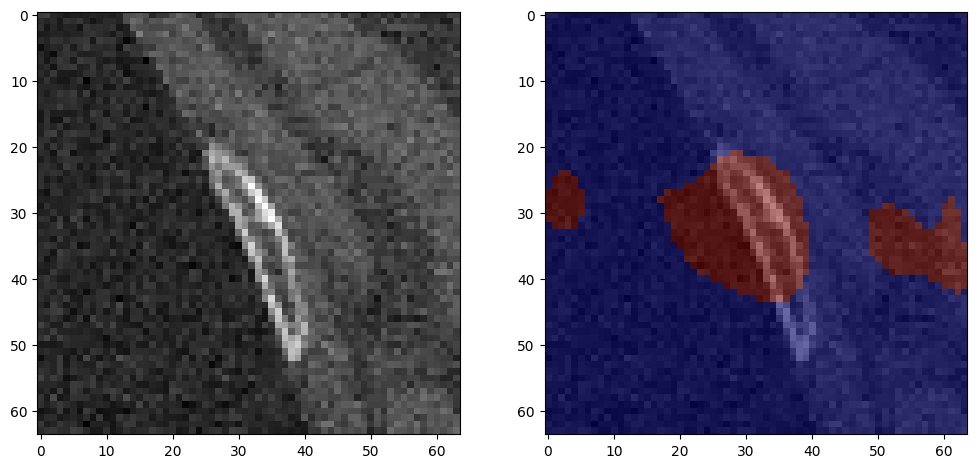

(1, 64, 64, 64)
(1, 64, 64, 64)


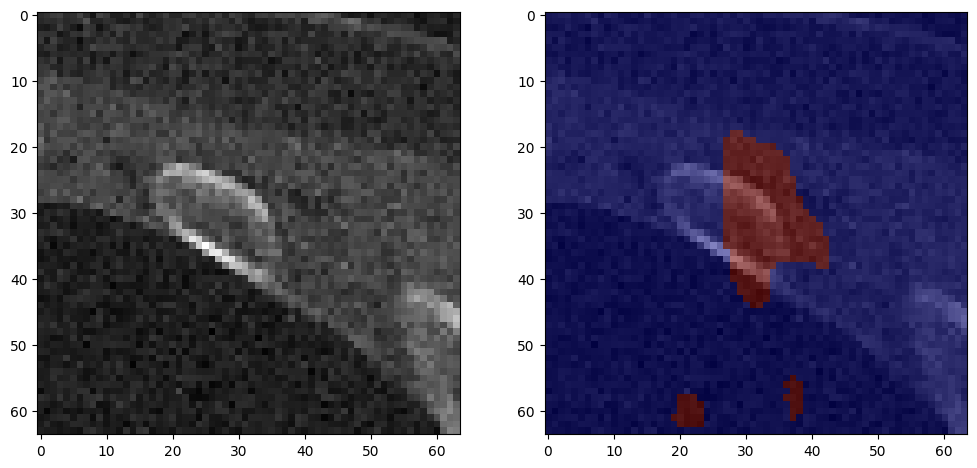

(1, 64, 64, 64)
(1, 64, 64, 64)


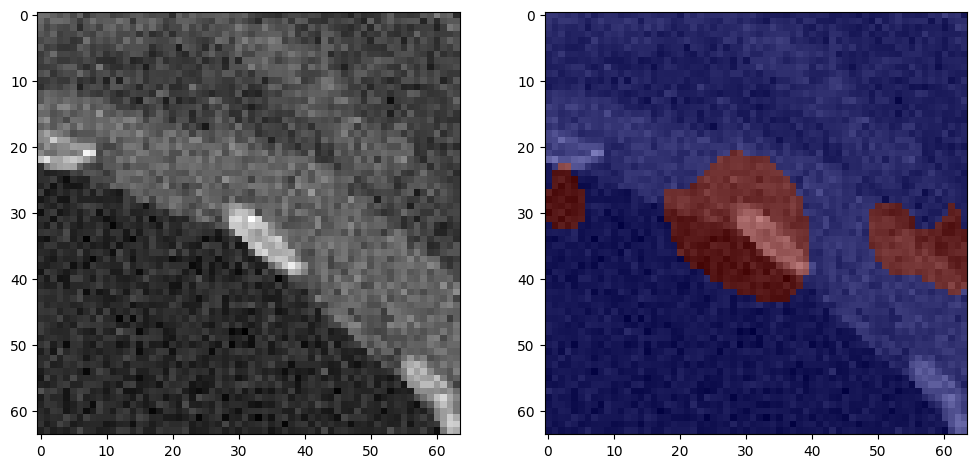

In [ ]:
threshold = 0.1
for x, y in dl_test:
    preds, _ = learn_UNetWithGCN_five50.get_preds(ds_type=DatasetType.Valid)
    pred_masks = (preds.sigmoid() > threshold).int()  # Convert predictions to binary masks
    # visualize the first image in the batch for example
    print(x[0].numpy().shape)
    print(pred_masks[0].numpy().shape)
    show_predictions_3d(x[0].numpy(), pred_masks[0].numpy(), slice_index=32)
      # Just show one batch for brevity

(16, 1, 64, 64, 64)
(160, 1, 64, 64, 64)
(16, 1, 64, 64, 64)


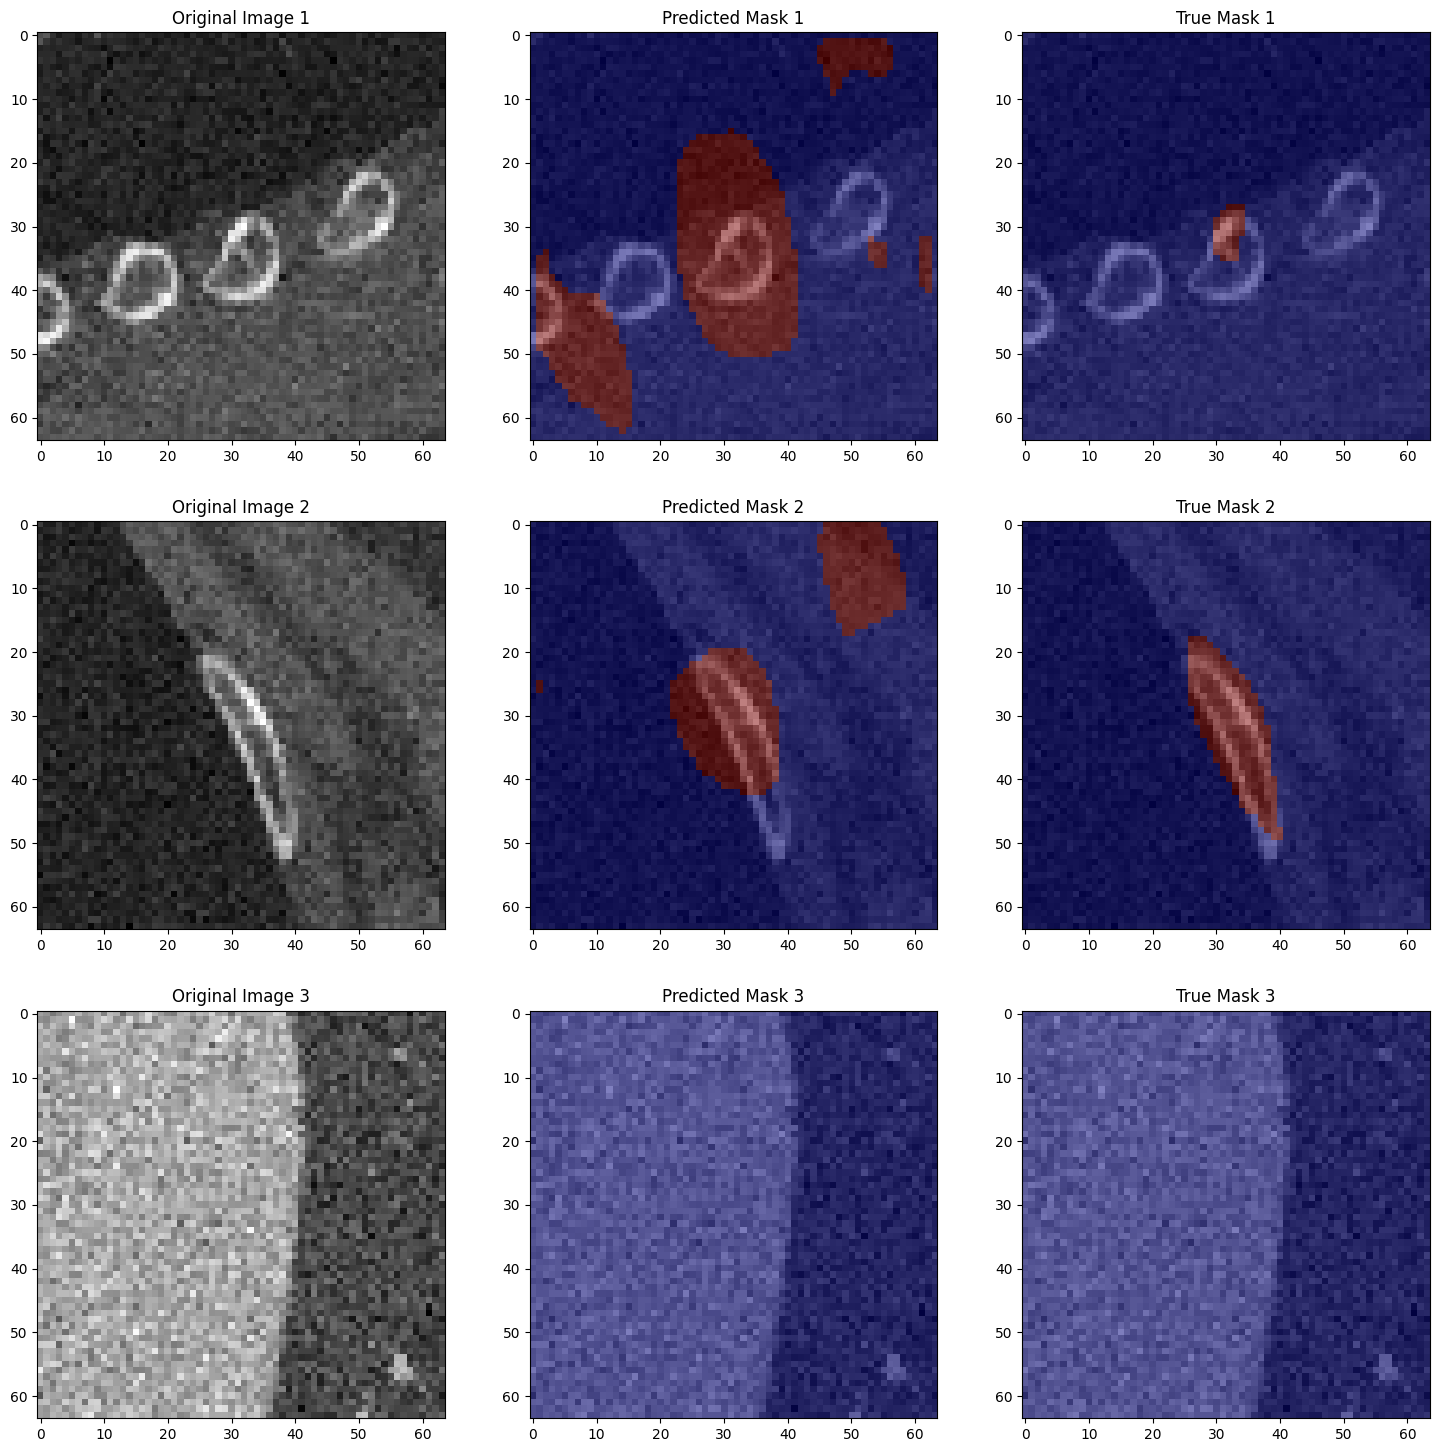

In [ ]:
import matplotlib.pyplot as plt

def show_predictions_3d(image_volume, pred_mask_volume, true_mask_volume, slice_index, num_instances=3):
    """
    Visualize the specific slice from the image volume, predicted mask volume, and true mask volume.

    Parameters:
        image_volume (numpy.ndarray): The 3D array of the image volume.
        pred_mask_volume (numpy.ndarray): The 3D array of the predicted mask volume.
        true_mask_volume (numpy.ndarray): The 3D array of the true mask volume.
        slice_index (int): The index of the slice to visualize.
        num_instances (int): The number of instances to visualize.
    """
    if not (0 <= slice_index < image_volume.shape[2]):
        raise ValueError(f"Slice index {slice_index} is out of bounds. Valid range is 0 to {image_volume.shape[2]-1}.")

    fig, axs = plt.subplots(num_instances, 3, figsize=(18, 6 * num_instances))

    for i in range(num_instances):
        # select the instance [i], and the slice_index on the depth dimension
        axs[i, 0].imshow(image_volume[i, 0, slice_index, :, :], cmap='gray')  # display the slice of the original image
        axs[i, 0].set_title(f"Original Image {i+1}")

        axs[i, 1].imshow(image_volume[i, 0, slice_index, :, :], cmap='gray')  # display the same slice for context
        axs[i, 1].imshow(pred_mask_volume[i, 0, slice_index, :, :], alpha=0.5, cmap='jet')  # overlay the predicted mask with transparency
        axs[i, 1].set_title(f"Predicted Mask {i+1}")

        axs[i, 2].imshow(image_volume[i, 0, slice_index, :, :], cmap='gray')  # display the same slice for context
        axs[i, 2].imshow(true_mask_volume[i, 0, slice_index, :, :], alpha=0.5, cmap='jet')  # overlay the true mask with transparency
        axs[i, 2].set_title(f"True Mask {i+1}")

    plt.show()

threshold = 0.1
slice_index = 32  # change the slice index as needed
num_instances_to_show = 3

for x, y in dl_test:
    preds, _ = learn_UNetWithGCN_five50.get_preds(ds_type=DatasetType.Valid)
    pred_masks = (preds.sigmoid() > threshold).int()  # convert predictions to binary masks

    print(x.numpy().shape)
    print(pred_masks.numpy().shape)
    print(y.numpy().shape)

    num_instances_to_show = min(num_instances_to_show, x.size(0))

    # show multiple sets of images, predictions, and true masks
    show_predictions_3d(x.numpy(), pred_masks.numpy(), y.numpy(), slice_index=slice_index, num_instances=num_instances_to_show)

    break  # only process the first batch for brevity
